In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
cd /content/gdrive/My Drive/edu/elice/AlzData

/content/gdrive/My Drive/edu/elice/AlzData


In [5]:
import os


In [6]:
os.listdir()

['AlzData.zip', 'test', 'train']

In [7]:
!pip install tensorflow==2.3.0 -q

     |████████████████████████████████| 320.4 MB 45 kB/s 
     |████████████████████████████████| 2.9 MB 41.0 MB/s 
     |████████████████████████████████| 20.1 MB 1.3 MB/s 
     |████████████████████████████████| 26.1 MB 1.2 MB/s 
     |████████████████████████████████| 459 kB 60.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.18.5 which is incompatible.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.18.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.4.1 which is incompatible.
jaxlib 0.3.14+cuda11.cudnn805 requires numpy>=1.19, but you have numpy 1.18.5 which is incompatible.
jaxlib 0.3.14+cuda11.cudnn805 requires scipy>=1.5, but you have scipy 1.4.1 which is incompatible.
jax 0.3.14 requires numpy>=1.19, but you have numpy 1.18.5 which 

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL

In [9]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.3.0


In [10]:
IMAGE_SIZE = [176, 208]
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
EPOCHS = 10
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './train',
    validation_split = 0.2,
    subset='training',
    seed = 1337,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
)

Found 4913 files belonging to 4 classes.
Using 3931 files for training.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './train',
    validation_split = 0.2,
    subset='validation',
    seed = 1337,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
)

Found 4913 files belonging to 4 classes.
Using 982 files for validation.


In [14]:
list_dir_classes = os.listdir('./train')
list_dir_classes

['VeryMildDemented', 'NonDemented', 'ModerateDemented', 'MildDemented']

In [15]:
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [16]:
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

In [26]:
train_ds

<BatchDataset shapes: ((None, 176, 208, 3), (None,)), types: (tf.float32, tf.int32)>

np.shape(images) (16, 176, 208, 3)


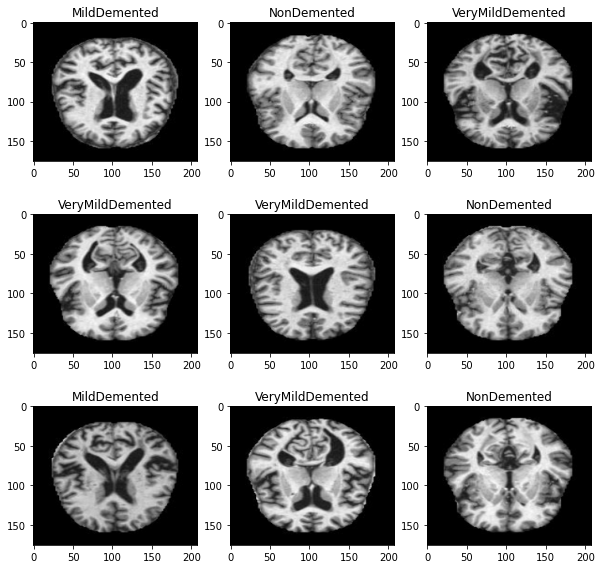

In [29]:
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
  print('np.shape(images)',np.shape(images))
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(train_ds.class_names[labels[i]])

In [30]:
def one_hot_label(image, label):
  label = tf.one_hot(label, NUM_CLASSES)
  return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls = AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls = AUTOTUNE)

In [31]:
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [34]:
NUM_IMAGES = []

for label in class_names:
    dir_name = "./train/" + label[:-2] + 'ed'
    print('dir_name', dir_name)
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

dir_name ./train/MildDemented
dir_name ./train/ModerateDemented
dir_name ./train/NonDemented
dir_name ./train/VeryMildDemented


In [35]:
NUM_IMAGES # imbalance data

[717, 52, 2560, 1792]

In [36]:
def conv_block(filters):
  block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
      tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()
  ]
  )
  return block


In [37]:
def dense_block(units, dropout_rate):
  block = tf.keras.Sequential([
      tf.keras.layers.Dense(units, activation = 'relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(dropout_rate)
  ]
  )
  return block

In [38]:
def build_model():
  model = tf.keras.Sequential([
      tf.keras.Input(shape=(*IMAGE_SIZE,3)),

      tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
      tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
      tf.keras.layers.MaxPool2D(),

      conv_block(32),
      conv_block(64),

      conv_block(128),
      tf.keras.layers.Dropout(0.2),

      conv_block(256),
      tf.keras.layers.Dropout(0.2),

      tf.keras.layers.Flatten(),
      dense_block(512, 0.7),
      dense_block(128, 0.5),
      dense_block(64, 0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax'),
  ]
  )
  return model